In [1]:
from Regression import Regression
from Franke import FrankeCentered, FrankeCenteredNoise

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import Lasso
import scipy.stats
import time
from imageio import imread
from tqdm import tqdm, trange

mpl.style.use("seaborn-darkgrid")
mpl.rcParams["image.cmap"] = "gnuplot2"
mpl.rcParams['figure.figsize'] = [6.0, 6.0]

np.random.seed(1942)

# 1. Setup

In [12]:
x, y = np.linspace(-0.5, 0.5, 101), np.linspace(-0.5, 0.5, 101)
reg = Regression()
reg.generate_generic_data(x, y, FrankeCenteredNoise)

## 1.1 Franke vs Franke with 1 sigma gaussian noise

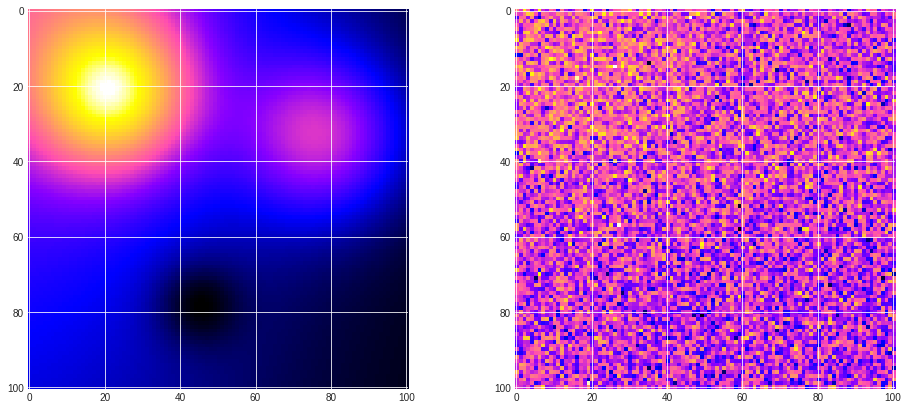

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
franke_noiseless = FrankeCentered(reg.x_mesh, reg.y_mesh)
ax1.imshow(franke_noiseless);
ax2.imshow(reg.f);

# 2. OLS Linear Regression

In [14]:
beta = reg.solveCoefficients(poly_order=5, solver="Ridge")
data_pred = reg.apply_model(beta, reg.x_mesh, reg.y_mesh)

## 2.1 Result: 5th order polyfit on entire dataset

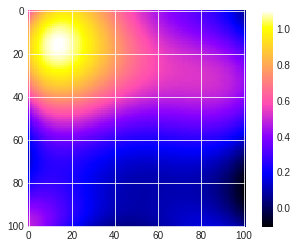

In [15]:
plt.imshow(data_pred);
plt.colorbar();

In [16]:
mse = MSE(reg.f, data_pred)
rmse = np.sqrt(mse)
rrmse = rmse/np.mean(reg.f)
r2 = r2_score(reg.f, data_pred)
print("metrics vs noisy franke (data trained on): ", mse, rmse, rrmse, r2)

mse = MSE(franke_noiseless, data_pred)
rmse = np.sqrt(mse)
rrmse = rmse/np.mean(reg.f)
r2 = r2_score(franke_noiseless, data_pred)
print("metrics vs noiseless franke: ", mse, rmse, rrmse, r2)

metrics vs noisy franke (data trained on):  1.0067249689384434 1.00335685024743 2.4207343084072335 0.04341769938087924
metrics vs noiseless franke:  0.004690757239385006 0.06848910307037906 0.16523923817694638 0.8270805751338858


## 2.2 Result: Trying different polynomial degrees

40it [00:51,  3.46s/it]


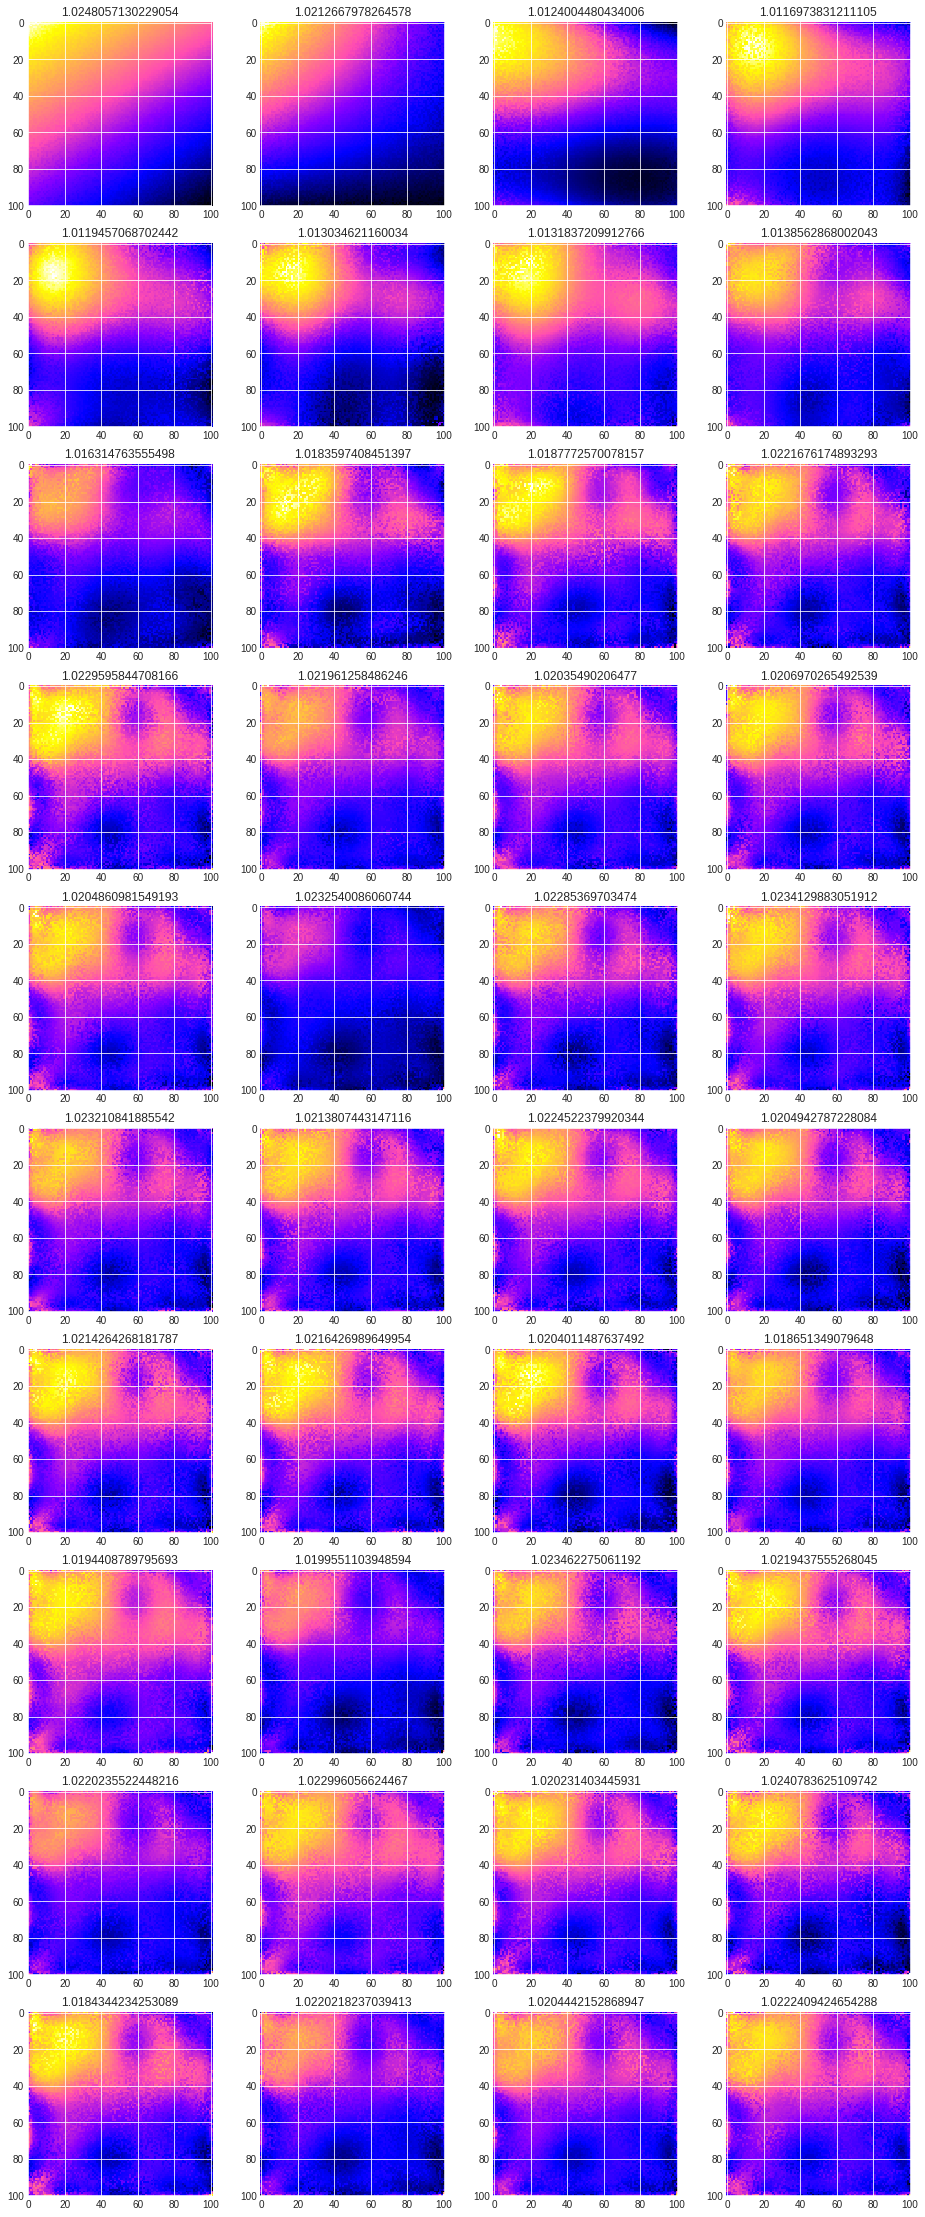

In [19]:
err_list = []
err_list_truemodel = []
nr_poly_orders = 40
poly_orders = np.arange(1, nr_poly_orders + 1)

fig, ax = plt.subplots(nr_poly_orders//4, 4, figsize=(16, 4*nr_poly_orders//4))

for i, poly_order in tqdm(enumerate(poly_orders)):
    #beta = reg.solveCoefficients(poly_order=poly_order, solver="OLS")
    #data_pred = reg.apply_model(beta, reg.x_mesh, reg.y_mesh)
    data_pred = reg.solveKFold(poly_order=poly_order)
    ax[i//4, i%4].imshow(data_pred)
    ax[i//4, i%4].set_title(MSE(data_pred, reg.f))
    err_list.append(MSE(reg.f, data_pred))
    err_list_truemodel.append(MSE(FrankeCentered(reg.x_mesh, reg.y_mesh), data_pred))    

## 2.3 Plotting log MSE vs noisy data and true model

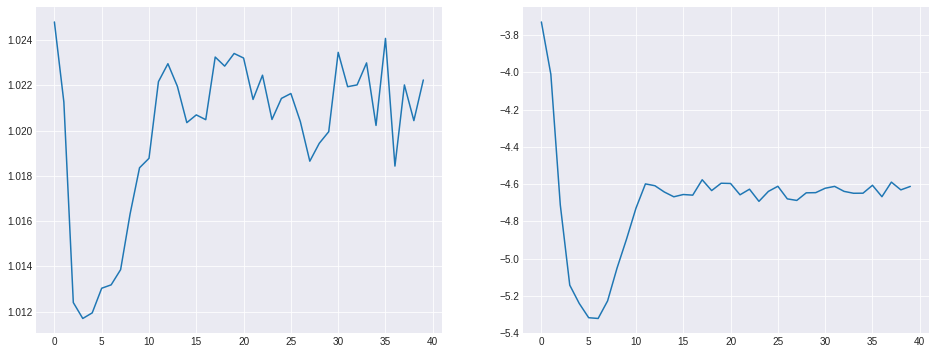

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.plot(err_list);
ax2.plot(np.log(err_list_truemodel));

# 3. Deriving Confidence Interval for betas

In [22]:
1/(X.shape[0] - X.shape[1] - 1)*np.sum((data_pred - reg.f)**2)

1.0055286230608027

In [12]:
X = reg.get_X(reg.x_flat, reg.y_flat, 5)

df = X.shape[0]*X.shape[1] - 1

beta = reg.get_beta(X, reg.f_flat)
data_pred = reg.apply_model(beta, reg.x_mesh, reg.y_mesh)
sigma_beta2 = 1/(X.shape[0] - X.shape[1] - 1)*np.sum((data_pred - reg.f)**2)
S_beta = np.linalg.pinv(X.T@X)

XTX_diag = np.diagonal(np.linalg.pinv(X.T@X))

t_05 = scipy.stats.t.cdf(0.05, df)
beta_cf = np.zeros((len(XTX_diag), 2))
beta_cf[:,0] = beta - t_05/np.sqrt(XTX_diag*sigma_beta2)
beta_cf[:,1] = beta + t_05/np.sqrt(XTX_diag*sigma_beta2)

In [13]:
XTX_diag

array([1.87985310e-04, 8.30178359e-03, 5.89865505e-02, 1.44750594e+00,
       1.04964035e+00, 1.64714712e+01, 8.30178359e-03, 4.01890066e-02,
       9.08463727e-01, 7.99429050e-01, 1.24709744e+01, 5.89865505e-02,
       9.08463727e-01, 7.70782599e-01, 1.18735904e+01, 1.44750594e+00,
       7.99429050e-01, 1.18735904e+01, 1.04964035e+00, 1.24709744e+01,
       1.64714712e+01])

In [16]:
beta_cf, sigma_beta2

(array([[-34.52462447,  35.22991559],
        [ -6.84873425,   3.64786778],
        [ -1.44807208,   2.48976674],
        [  9.28228226,  10.07720379],
        [ -4.67794916,  -3.74444947],
        [-17.87835101, -17.64270058],
        [ -5.45014676,   5.04645526],
        [ -0.71805864,   4.052627  ],
        [ -7.74351577,  -6.74010065],
        [ -1.39088431,  -0.32122747],
        [ 18.12087171,  18.39169389],
        [  0.2073093 ,   4.14514811],
        [ -3.77078871,  -2.76737359],
        [ -0.13732256,   0.95203006],
        [ -2.07950968,  -1.80195829],
        [ -2.35042699,  -1.55550546],
        [ -5.0000162 ,  -3.93035936],
        [ 13.4055693 ,  13.68312069],
        [-10.30876517,  -9.37526548],
        [ 19.23552922,  19.50635141],
        [  7.3760896 ,   7.61174003]]), 1.1822125771775303)

In [7]:
data_pred_min = reg.apply_model(beta_cf[:,0], reg.x_mesh, reg.y_mesh)
data_pred_max = reg.apply_model(beta_cf[:,1], reg.x_mesh, reg.y_mesh)

## TODO: Find confidence interval for f. Bootstrap?